In [127]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.svm import SVC

## Question 5) String kernels
*Note: data taken from https://cseweb.ucsd.edu/classes/wi17/cse151-a/hw5.pdf along with inspiration for this problem.*  

As we've seen, kernels have wide applications. We've seen kernels be a time efficient way to lift a feature matrix in many different contexts like PCA, Perceptrons, SVM's and Ridge Regression. One great property of kernels is the ability to supply any valid kernel function to one of our kernelized model it will work within that space.  
For this problem, we will be working with **string kernels**, which apply kernel functions to text data so that models like SVM can work with them. Remember kernel functions are essentially similarity functions. Therefore, string kernel functions generally tell us how similar two strings are. 


### Question 5a)
First, let's take a look at our data.

In [128]:
train_data = pd.read_csv('string_train.csv')
train_data.head()

,Sequence,Classification
0,SKDTGFVTYKNWPIYKDDTTIAMRKGTDGSQIVTILSNKGASGDSY...,-1
1,TIKVGINGFGRIGRMVFQALCDDGLLGNEIDVVAVVDMNTDARYFA...,-1
2,ADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTEA...,1
3,MAVQLFFTEEQRKVFKSSFKSIDADGDGKITPEELKAAFKSIEIEL...,1
4,TKPGSCPIILIRCAMLNPPNRCLKDTDCPGIKKCCEGSCGMACFVPQ,-1


The sequence is a sequence of amino acids, and the classification is whether or not the sequence belongs to a particular protein family or not.  
Visualize the number of positive and negative sequences we have using a barplot.

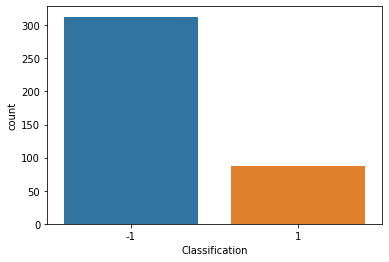

In [129]:
# START TODO
sns.countplot(x=train_data['Classification'])
# END TODO

Answer the following questions.  
* **Brainstorm some ways to deal with this text data. How can we compute similarity between two strings?**
* **Does the imbalance in data matter? Why or why not?**

### Question 5b)
For this problem, we are going to be using the **Spectrum Kernel**, one of the most simple string kernels. The basic idea behind the kernel is that two strings with more common substrings will be more similar. What is a substring? A substring is any contiguous sequence of characters within a string. The kernel function the **p-spectrum kernel** expresses this idea. $k(s_1, s_2)$ counts all size $p$ substrings that are present in both the string $s_1$ and the string $s_2$.   

Fill out the code below to finish the implementation of the kernel.  


*Note 1: There are many other valid string kernels, many of which are much better and domain specific than this one. For more string kernels, check here https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c11_p344-396.pdf. In fact, Michael I Jordan has a whole book on kernels for pattern recognition that might be fun to look at.*  
*Note 2: Section 1.4.6.2.2 https://scikit-learn.org/stable/modules/svm.html#kernel-functions might be useful.*

In [130]:
def p_spectrum(s, t, p):
    num_in_common = ...
    # START TODO
    num_in_common = 0
    for i in range(len(s) - p + 1):
        curr = s[i:i+p]
        if curr in t:
            num_in_common += 1
    # END TODO
    return num_in_common

Now that we have our kernel function defined, let's actually use it to classify our dataset. We will be using an SVM classifier. Unfortunately, scikit learn doesn't support string kernel functions for SVM's, but there are a few work arounds. The first work around is precomputing the **Gram matrix** $K$ for our data, and then running an SVM on it. Remember, all we need is the Gram matrix to do classification.  

*Note: it will take a few seconds to a minute to run this part of the code.*

In [136]:
X_train = np.array(train_data["Sequence"])
y_train = np.array(train_data["Classification"])

def compute_gram_matrix(X_one, X_two, y, p=3):
    # START COMPUTE GRAM MATRIX
    K = np.zeros((X_one.shape[0], X_two.shape[0]))
    for s_index, s in enumerate(X_one):
        for t_index, t in enumerate(X_two):
            K[s_index][t_index] = p_spectrum(s, t, p)
    # END COMPUTE GRAM MATRIX
    return K


In [137]:
K_train = ...
# START TODO
K_train = compute_gram_matrix(X_train, X_train, y_train)
# END TODO
print (K_train.shape)
K_train

(400, 400)


array([[101.,   3.,   6., ...,   3.,   2.,   0.],
       [  3., 188.,   4., ...,  12.,   1.,   3.],
       [  7.,   4., 146., ...,   6.,  37.,   2.],
       ...,
       [  3.,  13.,   5., ..., 147.,   3.,   2.],
       [  2.,   1.,  31., ...,   3.,  51.,   2.],
       [  0.,   3.,   2., ...,   2.,   2.,  29.]])

### Question 5c)
Now let's try some classifiers out. Let's start with the SVM classifier. Complete the below code to fit an SVM model with our precomputed Gram matrix and print out the accuracy on the train set.

In [138]:
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)
score = clf.score(K_train, y_train)

print ("Accuracy on the training data: " + str(score))

Accuracy on the training data: 1.0


Now calculate the accuracy on the testing data.

In [147]:
test_data = pd.read_csv('string_test.csv')
X_test = np.array(test_data["Sequence"])
y_test = np.array(test_data["Classification"])

# START TODO
K_test = compute_gram_matrix(X_test, X_train, y_test)
y_pred = clf.predict(K_test)

# END TODO
score = clf.score(K_test, y_test)
print ("Accuracy on the testing data: " + str(score))


Accuracy on the testing data: 0.975


Answer the following questions.  
* **What was your accuracy on the test dataset? Was it different from the training dataset?**
* **Can you think of any improvements to our kernel function?**

Congrats! You just used string kernels to classify a real dataset of Amino Acid sequences! Hopefully you can see the power of kernels from this example. Further applications include Graph kernels, Tree kernels, kernels for images... the possibilities are endless!  
If you want to learn more, read some of Michael I Jordan's stuff on this subject here: https://people.eecs.berkeley.edu/~jordan/kernels/0521813972pre_pi-xiv.pdf  
If you're interested in string kernels, here are some good papers to read that build upon the simple p-spectrum kernel we used in this example!  
* Mismatch kernels - https://papers.nips.cc/paper/2179-mismatch-string-kernels-for-svm-protein-classification.pdf 
* Gappy kernels - https://www.semanticscholar.org/paper/A-fast-%2C-large-scale-learning-method-for-protein-Kuksa-Huang/bd5a49164b7d0a9179ef5cb39148279825877a7f
* Motif kernels - https://almob.biomedcentral.com/articles/10.1186/1748-7188-1-21
* More spectrum kernels - https://pubmed.ncbi.nlm.nih.gov/11928508/